In [1]:
import json
from pathlib import Path
import numpy as np
from collections import defaultdict
from sort.sort import Sort  # pip install sort-tracker or clone from abewley/sort


In [2]:
def coco_bbox_to_sort_bbox(center_x, center_y, width, height):
    x1 = center_x - width / 2
    y1 = center_y - height / 2
    x2 = center_x + width / 2
    y2 = y1 + height
    return [x1, y1, x2, y2]


In [3]:
DATASET_DIR = Path("dataset_jpg/dataset")
ANN_FILE = DATASET_DIR / "annotations.json"

MAX_AGE = 30  # 1 to 30, 1 standard
MIN_HITS = 3  # 1 to 5, 3 standard
IOU_THRESHOLD = 0.3  # 0.0 to 1.0, 3.0 standard

with ANN_FILE.open("r") as f:
    coco_data = json.load(f)

annotations = coco_data['annotations']
images = coco_data['images']

# Build image_id → image_info
image_id_to_info = {img['id']: img for img in images}

# Group annotations by video_id and then by frame_id
video_frames = defaultdict(lambda: defaultdict(list))
for ann in annotations:
    img_info = image_id_to_info[ann['image_id']]
    video_id = ann['video_id']
    frame_id = img_info['frame_id']
    bbox = ann['bbox']
    category_id = ann['category_id']

    # Convert [center_x, center_y, w, h] → [x1, y1, x2, y2]
    x1, y1, x2, y2 = coco_bbox_to_sort_bbox(*bbox)
    video_frames[video_id][frame_id].append([x1, y1, x2, y2, 1.0])  # Confidence = 1.0


In [4]:
tracking_results = []  # To hold all frame tracking results

for video_id, frames in video_frames.items():
    tracker = Sort(max_age=MAX_AGE, min_hits=MIN_HITS, iou_threshold=IOU_THRESHOLD)
    sorted_frames = sorted(frames.items())

    for frame_id, detections in sorted_frames:
        dets_np = np.array(detections)
        tracks = tracker.update(dets_np)

        for track in tracks:
            x1, y1, x2, y2, track_id = track
            tracking_results.append({
                'video_id': video_id,
                'frame_id': frame_id,
                'track_id': int(track_id),
                'bbox': [float(x1), float(y1), float(x2 - x1), float(y2 - y1)]
            })


In [5]:
import csv

with open('sort_tracking_results.csv', 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['video_id', 'frame_id', 'track_id', 'bbox'])
    writer.writeheader()
    for row in tracking_results:
        writer.writerow(row)


# Evaluation

In [6]:
def compute_iou_matrix(gt_boxes, pred_boxes):
    """
    Compute an IoU matrix between two sets of boxes.
    Each box is [x, y, w, h]
    Returns a cost matrix where cost = 1 - IoU (for motmetrics)
    """
    iou_matrix = np.zeros((len(gt_boxes), len(pred_boxes)), dtype=np.float32)

    for i, (x1, y1, w1, h1) in enumerate(gt_boxes):
        xa1, ya1, xa2, ya2 = x1, y1, x1 + w1, y1 + h1
        area_gt = w1 * h1

        for j, (x2, y2, w2, h2) in enumerate(pred_boxes):
            xb1, yb1, xb2, yb2 = x2, y2, x2 + w2, y2 + h2
            area_pred = w2 * h2

            # Intersection
            inter_x1 = max(xa1, xb1)
            inter_y1 = max(ya1, yb1)
            inter_x2 = min(xa2, xb2)
            inter_y2 = min(ya2, yb2)

            inter_w = max(0, inter_x2 - inter_x1)
            inter_h = max(0, inter_y2 - inter_y1)
            inter_area = inter_w * inter_h

            union_area = area_gt + area_pred - inter_area
            iou = inter_area / union_area if union_area > 0 else 0.0
            iou_matrix[i, j] = 1.0 - iou  # for motmetrics: cost = 1 - IoU

    return iou_matrix

In [7]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from sort.sort import Sort
import motmetrics as mm

# Load your COCO-style explanation.json
# with open("explanation.json", "r") as f:
#     data = json.load(f)

# annotations = coco_data["annotations"]
# images = coco_data["images"]
videos = coco_data["videos"]

# Build index
image_by_id = {img["id"]: img for img in images}
anns_by_video = defaultdict(list)
for ann in annotations:
    anns_by_video[ann["video_id"]].append(ann)

# Init MOT accumulator
mm.lap.default_solver = 'lap'
acc = mm.MOTAccumulator(auto_id=True)

# Process a single video (repeat in loop for all)
video_id = 1  # iterate from 1 to 274
video_anns = anns_by_video[video_id]
tracker = Sort()

# Group annotations by frame
anns_by_frame = defaultdict(list)
for ann in video_anns:
    img = image_by_id[ann["image_id"]]
    anns_by_frame[img["frame_id"]].append(ann)

gt_all, pred_all = [], []

# Sort by frame_id
for frame_id in sorted(anns_by_frame.keys()):
    anns = anns_by_frame[frame_id]

    # Build detection list for SORT: [x1, y1, x2, y2, conf]
    dets = []
    gt_ids = []
    gt_boxes = []

    for ann in anns:
        x_center, y_center, w, h = ann["bbox"]
        x1, y1 = x_center - w / 2, y_center - h / 2
        x2, y2 = x1 + w, y1 + h
        dets.append([x1, y1, x2, y2, 1.0])  # dummy conf
        gt_ids.append(ann["cell_id"])
        gt_boxes.append([x1, y1, w, h])

        # Save GT
        gt_all.append([frame_id + 1, ann["cell_id"], x1, y1, w, h])  # 1-based frame

    dets_np = np.array(dets)
    tracks = tracker.update(dets_np)

    # Save predictions for motmetrics
    # pred_boxes = [trk["bbox"] for trk in tracking_results[(video_id, frame_id)]]
    # pred_ids = [trk["track_id"] for trk in tracking_results[(video_id, frame_id)]]
    pred_ids = []
    pred_boxes = []
    for track in tracks:
        x1, y1, x2, y2, track_id = track
        w, h = x2 - x1, y2 - y1
        pred_all.append([frame_id + 1, int(track_id), x1, y1, w, h])
        pred_ids.append(track_id)
        pred_boxes.append([x1, y1, w, h])

    # Match predictions to GT using bbox IoU
    from motmetrics.utils import iou_matrix

    if gt_boxes and pred_boxes:
        distances = compute_iou_matrix(gt_boxes, pred_boxes)
        distances[distances > (1 - 0.5)] = np.nan  # Apply IoU threshold (max_iou = 0.5)
        acc.update(gt_ids, pred_ids, distances)
    else:
        acc.update(gt_ids, [], np.array([]))  # no pred

# Save CSVs (optional)
pd.DataFrame(gt_all, columns=["frame", "id", "x", "y", "w", "h"]).to_csv("gt.csv", index=False)
pd.DataFrame(pred_all, columns=["frame", "id", "x", "y", "w", "h"]).to_csv("pred.csv", index=False)

# Evaluate
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=mm.metrics.motchallenge_metrics, name='SORT')
print(mm.io.render_summary(summary, formatters=mh.formatters, namemap=mm.io.motchallenge_metric_names))
# summary = mh.compute(acc, name='SORT')
# print(mm.io.render_summary(summary, formatters=mh.formatters))
print(f"Processed {len(gt_all)} frames")


      IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML FP  FN IDs  FM  MOTA  MOTP IDt IDa IDm
SORT 83.8% 87.8% 80.3% 91.3% 99.9% 81 70  9  2  6 483  56  71 90.2% 0.088  12  55  11
Processed 5579 frames


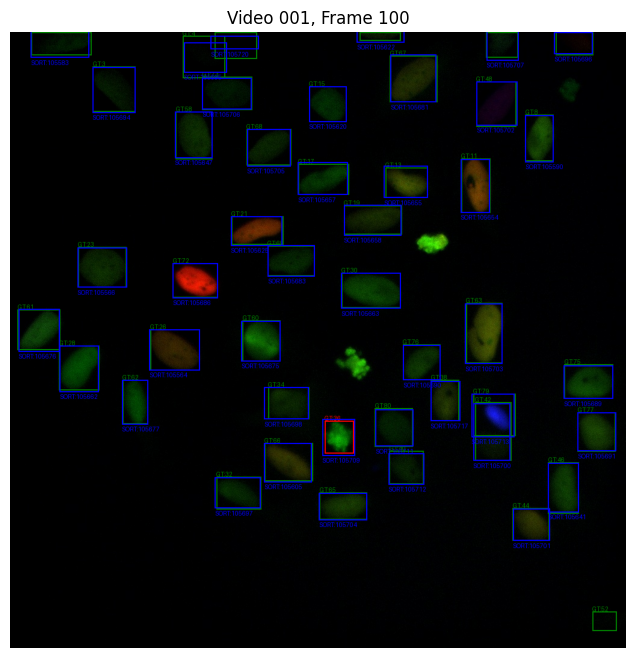

In [8]:
%matplotlib inline
import os
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Load annotations
# with open("explanation.json") as f:
#     data = json.load(f)

# annotations = data["annotations"]
# images = data["images"]
image_by_id = {img["id"]: img for img in images}

# Map annotations per image
from collections import defaultdict
anns_by_image = defaultdict(list)
for ann in annotations:
    anns_by_image[ann["image_id"]].append(ann)

# Load GT and SORT predictions
import pandas as pd
gt_df = pd.read_csv("gt.csv")    # columns: frame, id, x, y, w, h
pred_df = pd.read_csv("pred.csv")  # same format with SORT track_ids

def draw_frame(video_id, frame_id, img_dir="dataset_jpg/dataset"):
    # Find image metadata
    image_info = next(img for img in images if img["video_id"] == video_id and img["frame_id"] == frame_id)
    image_id = image_info["id"]
    filename = os.path.join(img_dir, f"{video_id:03d}/images", os.path.basename(image_info["file_name"]))

    # Load image
    img = Image.open(filename).convert("RGB")
    draw = ImageDraw.Draw(img)

    # Load ground truth boxes
    for ann in anns_by_image[image_id]:
        x_center, y_center, w, h = ann["bbox"]
        x1 = x_center - w / 2
        y1 = y_center - h / 2
        x2 = x1 + w
        y2 = y1 + h
        category = ann["category_id"]  # 1 = living, 2 = dead
        cell_id = ann["cell_id"]

        color = "green" if category == 1 else "red"
        draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
        draw.text((x1, y1 - 10), f"GT:{cell_id}", fill=color)

    # Load SORT predictions
    preds = pred_df[pred_df["frame"] == frame_id + 1]  # 1-based in pred.csv
    for _, row in preds.iterrows():
        x, y, w, h = row[2:6]
        x1, y1, x2, y2 = x, y, x + w, y + h
        track_id = int(row["id"])
        draw.rectangle([x1, y1, x2, y2], outline="blue", width=2)
        draw.text((x1, y2 + 2), f"SORT:{track_id}", fill="blue")

    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Video {video_id:03d}, Frame {frame_id}")
    plt.axis("off")
    plt.show()

# Example: Show frame 5 of video 1
draw_frame(video_id=1, frame_id=100)

# NEW VERSION

In [9]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from sort.sort import Sort
import motmetrics as mm

DATASET_DIR = Path("dataset_jpg/dataset")
ANN_FILE = DATASET_DIR / "annotations.json"

# === CONFIG ===
MAX_AGE = 1
MIN_HITS = 3
IOU_THRESHOLD = 0.3

# === Load Annotations ===
with ANN_FILE.open("r") as f:
    data = json.load(f)

annotations = data["annotations"]
images = data["images"]
image_by_id = {img["id"]: img for img in images}

# Group annotations by (video, frame)
video_frames = defaultdict(lambda: defaultdict(list))
for ann in annotations:
    img = image_by_id[ann["image_id"]]
    video_id = ann["video_id"]
    frame_id = img["frame_id"]

    x, y, w, h = ann["bbox"]
    x1, y1 = x - w / 2, y - h / 2
    x2, y2 = x1 + w, y1 + h
    bbox = [x1, y1, x2, y2, 1.0]  # dummy confidence

    video_frames[video_id][frame_id].append(bbox)

# === Tracking with SORT ===
tracking_results = []

for video_id, frames in video_frames.items():
    tracker = Sort(max_age=MAX_AGE, min_hits=MIN_HITS, iou_threshold=IOU_THRESHOLD)
    sorted_frames = sorted(frames.items())

    for frame_id, detections in sorted_frames:
        dets_np = np.array(detections)
        tracks = tracker.update(dets_np)

        for track in tracks:
            x1, y1, x2, y2, track_id = track
            tracking_results.append({
                "video_id": video_id,
                "frame_id": frame_id,
                "track_id": int(track_id),
                "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)]
            })

# === Organize GT and Predictions for Evaluation ===

# Build ground truth per video/frame
gt_by_video_frame = defaultdict(list)
for ann in annotations:
    img = image_by_id[ann["image_id"]]
    x, y, w, h = ann["bbox"]
    x1, y1 = x - w / 2, y - h / 2
    video_id = ann["video_id"]
    frame_id = img["frame_id"]
    gt_by_video_frame[(video_id, frame_id)].append((ann["cell_id"], [x1, y1, w, h]))

# Group predictions
pred_by_video_frame = defaultdict(list)
for trk in tracking_results:
    pred_by_video_frame[(trk["video_id"], trk["frame_id"])].append((trk["track_id"], trk["bbox"]))

# === Custom IoU matrix ===
def compute_iou_matrix(gt_boxes, pred_boxes):
    iou_matrix = np.zeros((len(gt_boxes), len(pred_boxes)), dtype=np.float32)
    for i, (x1, y1, w1, h1) in enumerate(gt_boxes):
        xa1, ya1, xa2, ya2 = x1, y1, x1 + w1, y1 + h1
        area_gt = w1 * h1

        for j, (x2, y2, w2, h2) in enumerate(pred_boxes):
            xb1, yb1, xb2, yb2 = x2, y2, x2 + w2, y2 + h2
            area_pred = w2 * h2

            inter_x1 = max(xa1, xb1)
            inter_y1 = max(ya1, yb1)
            inter_x2 = min(xa2, xb2)
            inter_y2 = min(ya2, yb2)

            inter_w = max(0, inter_x2 - inter_x1)
            inter_h = max(0, inter_y2 - inter_y1)
            inter_area = inter_w * inter_h

            union = area_gt + area_pred - inter_area
            iou = inter_area / union if union > 0 else 0.0
            iou_matrix[i, j] = 1.0 - iou  # motmetrics expects cost
    return iou_matrix

# === MOT Evaluation ===
acc = mm.MOTAccumulator(auto_id=True)

for key in sorted(gt_by_video_frame.keys()):
    gt = gt_by_video_frame[key]
    pred = pred_by_video_frame.get(key, [])

    gt_ids = [g[0] for g in gt]
    gt_boxes = [g[1] for g in gt]

    pred_ids = [p[0] for p in pred]
    pred_boxes = [p[1] for p in pred]

    if gt_boxes and pred_boxes:
        distances = compute_iou_matrix(gt_boxes, pred_boxes)
        distances[distances > (1 - 0.5)] = np.nan  # IoU threshold = 0.5
        acc.update(gt_ids, pred_ids, distances)
    else:
        acc.update(gt_ids, pred_ids, np.empty((len(gt_ids), len(pred_ids))))

# === Print Metrics ===
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=mm.metrics.motchallenge_metrics, name="SORT")
print(mm.io.render_summary(summary, formatters=mh.formatters, namemap=mm.io.motchallenge_metric_names))

print(f"\n✅ Processed {acc.events['FrameId'].nunique()} frames")


MemoryError: Unable to allocate 44.3 GiB for an array with shape (77073, 77073) and data type float64